# Splitting Parallelizing QCNN architecture test
Test of the architecture from the code [Splitting and Parallelizing of Quantum Convolutional Neural Networks for Learning Translationally Symmetric Data](https://arxiv.org/abs/2306.07331)

In [1]:
import numpy     as np 
import pennylane as qml 

# Type Hinting
from typing import List


_"To ensure the equivalene of outputs in the parallel computation, we also impose translational symmetry on each of the `convolutional` and `fully connected layers`, whose unitary is denoted by $V_i$ as follows:"_
$$T V_i T^\dagger = V_i$$
where $T$ is the translational operator by one qubit (e.g $\quad T|100...\rangle = |010...\rangle$)

$$V_i =  \prod_{k=1}^d R_{ZZ}^{sym}(\delta_k)R_X^{sym}(\gamma_k)R_Z^{sym}(\beta_k)R_X^{sym}(\alpha_k)$$

In [2]:
def Vi(qubits_indexes : List[int], P : List[float], p_0 : int, d : int):
    """
    Implementation of the convolutional block in the sp-QCNN architecture

    Parameters
    ----------
    qubits_indexes : List[int]
        List of the indexes involved in the convolution
    P : List[float]
        Array of trainable parameters
    p_0 : int 
        Starting index of the parameters array 
    d : int 
        Number of repetition (parameters will be different!)

    Returns
    -------
    int
        number of free parameters required
    """ 
    
    def RZZ(qubit1 : int, qubit2 : int, param):
        qml.CNOT(wires=[qubit1, qubit2])
        qml.RZ(param, wires=[qubit2])
        qml.CNOT(wires=[qubit1, qubit2])

    n_qubits_block = len(qubits_indexes)

    # if the number of qubits in the circuit block is not even...
    # This implies that the number of input qubits in the full 
    # sp-QCNN has to be a power of 2
    if n_qubits_block % 2 != 0: 
        raise ValueError(f"Number of input qubits in the circuit block Vi is not even, passed {n_qubits_block}")
    
    p = p_0

    for _ in range(d):
        # Apply some free rotations for each wire
        for q_index in qubits_indexes:
            qml.RX(P[p],   wires = [q_index])
            qml.RZ(P[p+1], wires = [q_index])
            qml.RX(P[p+2], wires = [q_index])

        p+=3

        # Even connections 
        for qubit, qubit_next in zip(qubits_indexes[0::2], qubits_indexes[1::2]):
            RZZ(qubit, qubit_next, p)

        # Odd  connections 
        for qubit, qubit_next in zip(qubits_indexes[1::2], qubits_indexes[2::2]):
            RZZ(qubit, qubit_next, p)

        if len(qubits_indexes) > 2:
            # Wrap-around connection
            RZZ(qubits_indexes[-1], qubits_indexes[0], p)

        p+=1

    return p 


(<Figure size 1500x500 with 1 Axes>, <Axes:>)

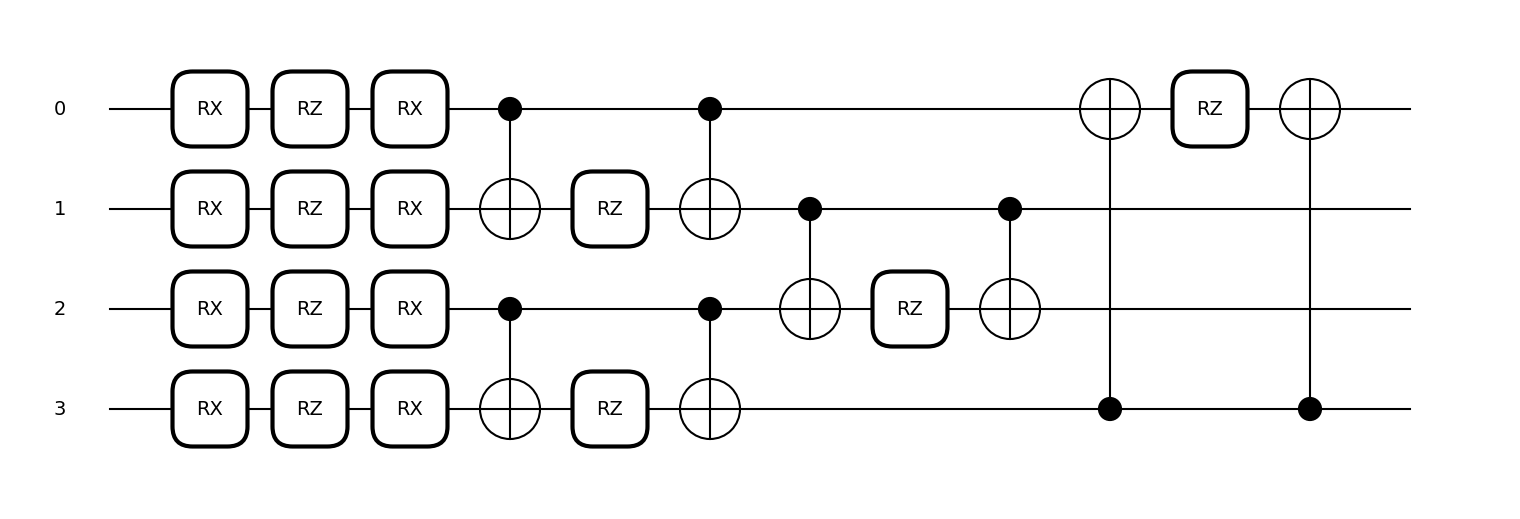

In [3]:
qml.draw_mpl(Vi)(np.arange(4), np.ones(10), 0, 1)

In [4]:
# FORWARD SHIFT : T|100> = |010>
def T(n_qubits : int):
    qubit = 0
    for qubit_next in np.arange(1,n_qubits):
        qml.SWAP(wires = [qubit, qubit_next])

# BACKWARD SHIFT TD|010> = |100>
def T_dag(n_qubits : int):
    for qubit, qubit_next in zip(np.arange(0, n_qubits), np.arange(1, n_qubits)):
        qml.SWAP(wires = [qubit, qubit_next])

In [5]:
Tmat     = qml.matrix(T)(4)
Tmat_dag = qml.matrix(T_dag)(4)

Vi_mat = qml.matrix(Vi)(np.arange(4), np.ones(10), 0, 1)

In [10]:
print('T = ')
print(qml.matrix(T)(3))

T = 
[[1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]]


## Is the circuit block $V_i$ translationally invariant?

"To ensure the equivalence of outputs in the parallel computation, we also impose translational symmetry on each o the convolutional and fully connected layers, whose unitary is denoted by $V_i$, as follows:
$$TV_iT^\dagger = V_i\qquad "$$

In [279]:
np.isclose(Tmat @ Vi_mat @ Tmat_dag, Vi_mat, atol=1e-8).all()

True

## sp-QCNN full circuit

In [291]:
def split_idxs(IDXS : List[int], debug : bool = False):
    SPLITS = []
    for idxs in IDXS:
        up, down = [], []
        for i, idx in enumerate(idxs):
            up.append(idx) if i % 2 == 0 else down.append(idx)
            
        SPLITS.append(up)
        SPLITS.append(down)

    return SPLITS

def spQCNN_func(n_qubits : int, P : List[float], d : int = 1):
    IDXS = [np.arange(n_qubits)]
    p = 0
    while len(IDXS) < n_qubits:
        for i, idxs in enumerate(IDXS):
            if i == len(IDXS) - 1:
                p = Vi(idxs, P, p, d)
            else:
                _ = Vi(idxs, P, p, d)
        IDXS = split_idxs(IDXS)
        qml.Barrier() 

In [292]:
print(qml.draw(spQCNN_func)(4, np.arange(100), 1))

0: ──RX(0.00)──RZ(1.00)──RX(2.00)─╭●───────────╭●─────────────────╭X──RZ(3.00)─╭X──||──RX(4.00)
1: ──RX(0.00)──RZ(1.00)──RX(2.00)─╰X──RZ(3.00)─╰X─╭●───────────╭●─│────────────│───||──────────
2: ──RX(0.00)──RZ(1.00)──RX(2.00)─╭●───────────╭●─╰X──RZ(3.00)─╰X─│────────────│───||──RX(4.00)
3: ──RX(0.00)──RZ(1.00)──RX(2.00)─╰X──RZ(3.00)─╰X─────────────────╰●───────────╰●──||──RX(4.00)

───RZ(5.00)──RX(6.00)─╭●───────────╭●────────────────────────────────────────────────||─┤  
──────────────────────│────────────│───RX(4.00)──RZ(5.00)──RX(6.00)─╭●───────────╭●──||─┤  
───RZ(5.00)──RX(6.00)─╰X──RZ(7.00)─╰X───────────────────────────────│────────────│───||─┤  
───RZ(5.00)──RX(6.00)───────────────────────────────────────────────╰X──RZ(7.00)─╰X──||─┤  


(<Figure size 2900x500 with 1 Axes>, <Axes:>)

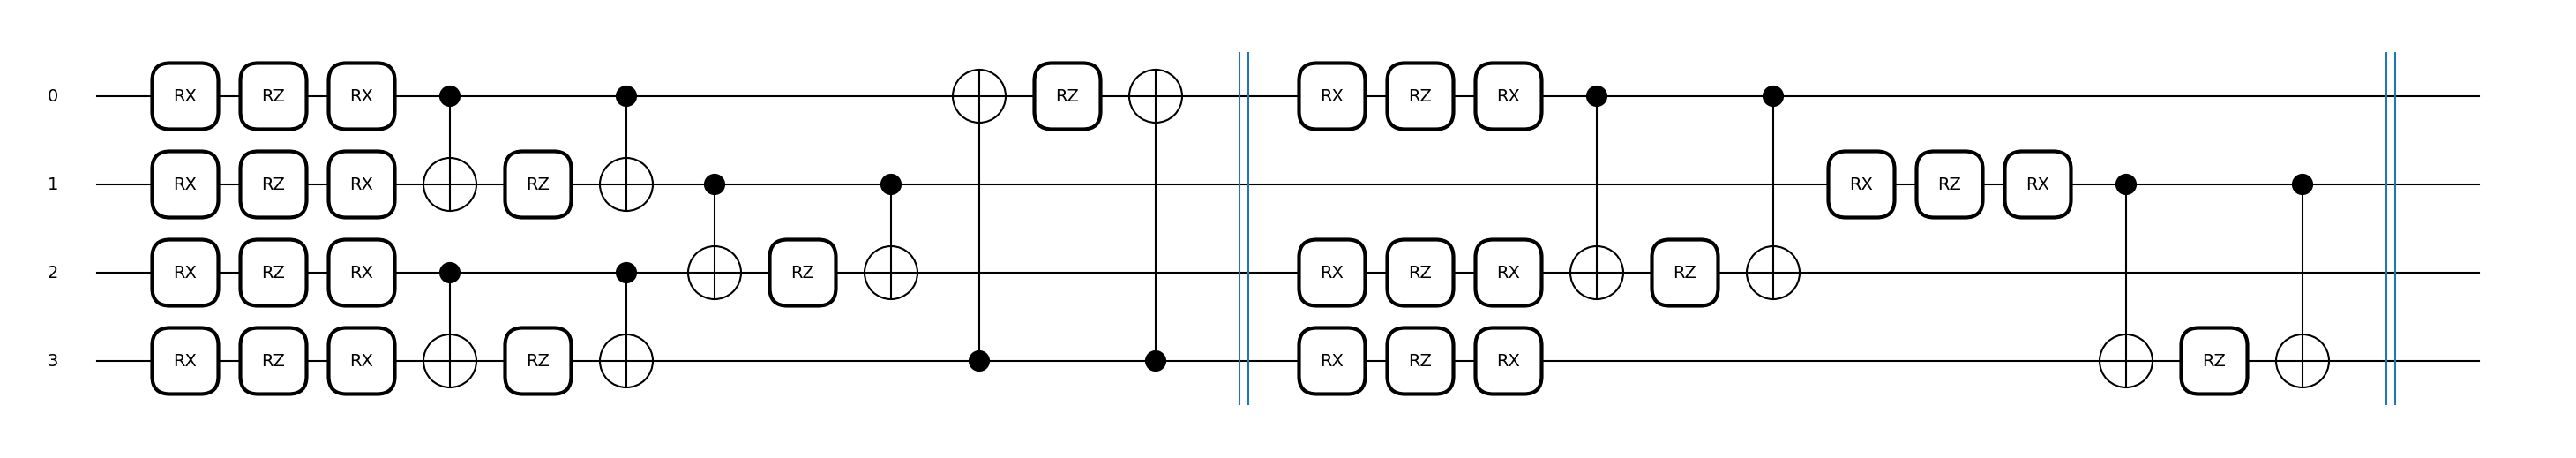

In [293]:
qml.draw_mpl(spQCNN_func)(4, np.random.rand(1000), 1)

## Are the outputs all equivalent?

In [294]:
device = qml.device("default.qubit", wires=8, shots=None)

@qml.qnode(device)
def q_spQCNN_func(n_qubits : int, P : List[float], d : int = 1):
    # Inputs are missing, we start from the state |00...0>
    # which is transationally invariant anyway 
    spQCNN_func(n_qubits = n_qubits, P = P, d = d)

    return qml.state()

Let Q be the full operator representing the sp-QCNN circuit.

Are the final measurements equivalent? 

In other words we can say...

$$T(Q|0\rangle) = Q|0\rangle \quad? $$

In [299]:
rho = q_spQCNN_func(8, np.random.rand(100), 1)

Tmat8     = qml.matrix(T)(8)
Tmat8_dag = qml.matrix(T_dag)(8)

np.isclose(Tmat8 @ rho, rho).all()

tensor(True, requires_grad=True)

## Is their Hamiltonian translationally symmetric?

In [11]:
def get_H(N: int, h1: float, h2: float):
    # Interaction of spins with magnetic field
    H = -h1 * qml.PauliX(0)
    for i in range(1, N):
        H = H - h1 * qml.PauliX(i)

    # Interaction between spins (neighbouring):
    for i in range(0, N - 1):
        H = H + (-h2) * (qml.PauliX(i) @ qml.PauliX(i + 1))

    # Periodic Boundary condition
    H = H + (-h2) * (qml.PauliX(N - 1) @ qml.PauliX(0))

    # Interaction between spins (next-neighbouring):
    for i in range(0, N - 2):
        H = H + (-1) * (qml.PauliZ(i) @ qml.PauliX(i + 1) @ qml.PauliZ(i + 2))

    # Periodic Boundary condition
    H = H + (-1) * (qml.PauliZ(N - 1) @ qml.PauliX(0)     @ qml.PauliZ(1))
    H = H + (-1) * (qml.PauliZ(N - 2) @ qml.PauliX(N - 1) @ qml.PauliZ(0))
    
    return H

In [16]:
N = 6
H = qml.matrix(get_H(N, 1, 1))

In [17]:
Tmat     = qml.matrix(T)(N)
Tmat_dag = qml.matrix(T_dag)(N) 

$$T H T^\dagger = H \quad ?$$

In [20]:
(Tmat @ H @ Tmat_dag == H).all()

True